# 5장. 차원 축소를 사용한 데이터 압축

특성 추출 - 데이터 압축하기:  
* 주성분 분석 - 비지도 데이터 압축
* 선형 판별 분석 - 지도 방식 차원 축소 기법
* 커널 PCA - 비선형 차원 축소

## 5.1 주성분 분석을 통한 비지도 차원 축소

새로운 특성 공간으로 데이터를 변환하거나 투영  
대부분의 관련 있는 정보를 유지하면서 데이터를 압축  
특히 규제가 없는 모델로 작업할 때 차원의 저주 문제를 감소시켜 예측 성능을 향상

### 5.1.1 주성분 분석의 주요 단계

*USAGE)* exploratory data analysis, 주식 거래 시장의 잡음 제거, 게놈 데이터나 유전자 발현 분석 등에 이용  
PCA는 고차원 데이터에서 분산이 가장 큰 방향을 찾고 좀 더 작거나 같은 수의 차원을 갖는 새로운 부분 공간으로 이를 투영  
차원을 축소하기 위해 $d\times k$ 차원의 변환 행렬 $\mathbf{W}$ 를 만듦  
원본 $d$ 차원 데이터를 새로운 $k$ 차원의 부분 공간으로 변환하여 만들어진 첫번재 주성분이 가장 큰 분산을 가짐  

이를 정리하면:  
1) $d$ 차원 데이터셋을 *표준화 전처리*
2) *공분산 행렬*을 만듦
3) 공분산 행렬을 *고유 벡터*와 *고유값*으로 분해
4) 고유값을 내림차순으로 정렬하고 그에 해당하는 고유 벡터의 순위를 매김
5) 고유값이 가장 큰 $k$ 개의 고유 벡터를 선택
6) 최상위 $k$ 개의 고유 벡터로 *투영 행렬* $\mathbf{W}$ 를 만듦
7) 투영 행렬을 이용하여 새로운 차원의 특성 부분 공간으로 변환  

### 5.1.2 주성분 추출 단계

1번 과정부터 4번 과정까지

In [1]:
# Wine 데이터셋 로드
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

In [2]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y,
                     random_state=0)

# 특성을 표준화 전처리
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

두 특성 $x_j$와 $x_k$ 사이의 공분산  
$$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^n (x_j^{(i)}-\mu_j)(x_k^{(i)}-\mu_k)$$

In [3]:
# 공분산 행렬 구하기 -> 고유 벡터와 고유값 쌍 구하기
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n고유값 \n%s' % eigen_vals)


고유값 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


### 5.1.3 총 분산과 설명된 분산

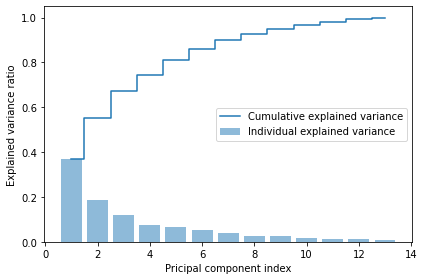

In [5]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
           sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Pricipal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 5.1.4 특성 변환

5번 과정에서 7번 마지막까지  

* 고유값이 가장 큰 고유 벡터를 선택
* 최상위 고유 벡터로 투영 행렬을 만듦
* 투영 행렬을 사용해서 새로운 차원의 특성 부분 공간으로 변환


In [6]:
# (고유값, 고유벡터) 튜플의 리스트를 만듦
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]
# 내림차순으로 튜플을 정렬
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [7]:
# 고유벡터로부터 투영행렬 만들기
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [10]:
# 샘플을 PCA 부분 공간으로 투영
X_train_pca = X_train_std.dot(w)

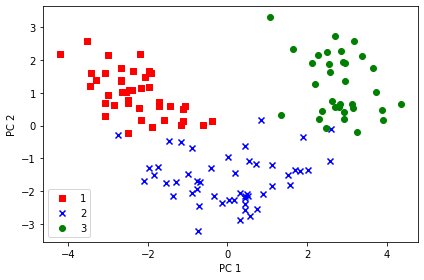

In [11]:
# 산점도로 시각화
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()